In [1]:
import sys
sys.path.append("..")

import pickle
import numpy as np
import pandas as pd

# Helper classes for data processing, state representation
from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
from reinforcetrader.state import EpisodeStateLoader
from reinforcetrader.dqn_agent import DRLAgent
from reinforcetrader.backtest_engine import EDBacktester

# Helper method for displaying large dataframes
from IPython.display import HTML
pd.set_option("display.max_rows", None)
from IPython.display import HTML, display

def display_df(df, rows=10):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

# Test DQN Agent Performance on OOS Data
To run the backtest, we must first set up a few things: replicate the WFV state loader, and load the model and its configuration.

## Get WFV State Loader

In [2]:
# Get DJI raw data using Yahoo Finance API
data_loader = RawDataLoader(start_date='1999-08-01', end_date='2025-09-08', index='DJI', verbose=False)

# Load the data from cache
ticker_data, benchmark_data = data_loader.get_hist_prices()

# Build features for state representation, reward computation, etc.
feature_builder = FeatureBuilder(ticker_data=ticker_data, benchmark_data=benchmark_data, f_prefix='DJI')
feature_builder.build_features()

# Store the computed features and the feature index ranges (used later)
features_data = feature_builder.get_features()
feature_indices = feature_builder.get_feature_indices()

Building ticker features: 100%|█████████████████████████████████████| 28/28 [00:03<00:00,  8.16it/s]

File already exists, skipping save: ../data/processed/DJI_tickers_features_2000-04-07_2025-09-04.csv


In [3]:
# Define the Walk-Forward Validation configuration
WFV_config = {
    'mode': 'expanding', # supports 'expanding' and 'moving'
    'train_start': '2000-04-07',
    'train_end': '2019-09-30',
    'test_start': '2019-10-01',
    'test_end': '2025-07-31',
    'train_window_size': 1200,
    'val_window_size': 630
}

In [4]:
# Initialize the episode state loader
state_loader = EpisodeStateLoader(features_data, feature_indices, WFV_config)

## Load the Trained Agent

In [5]:
# Create RL agent and testing configuration
# NOTE: Many of the params are NOT used in testing, but are used to define the agent. Thus, defining them is optional
agent_config = {
    'num_features': len(feature_indices['State']),
    'learning_rate': 1e-3,
    'dropout_p': 0.1,
    'memory_buffer_len': 200000,
    'state_matrix_window': 60,
    'epsilon_start': 1.0,
    'epsilon_min': 0.05,
    'epsilon_boost_factor': 0.3,
    'decay_updates': 50000,
    'discount_factor': 0.95,
    'batch_size': 256,
    'replay_start_size': 5000,
    'train_interval': 1,
}

test_config = {
    'plots_dir': '../plots/',
    'logs_dir': '../logs/',
    'outputs_dir': '../data/test/'
}

# Set the trained model path here
MODEL_PATH = '../model_checkpoints/DDQN_DSRC_AE1-44.keras'

# Load DRL Agent
trained_agent = DRLAgent(agent_config=agent_config, reward_type='DSR', model_path=MODEL_PATH)

I0000 00:00:1766788571.926176  240214 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Loading model from ../model_checkpoints/DDQN_DSRC_AE1-44.keras


## Test Agent Performance From 2020-2025

In [6]:
# Run event-driven backtest, i.e., run DRL agent and account for portfolio constraints during executions
backtester = EDBacktester(trained_agent, state_loader, index='DJI', cash=100_000, tc=0.25, max_pos=5)
portfolio_hist, trade_logs = backtester.run_backtest()

Starting Event-Driven Backtest. Initial Cash Balance: 100000.00; Max Positions: 5


Trading Days: 100%|█████████████████████████████████████████████████████| 1406/1406 [25:35<00:00,  1.09s/it]


In [7]:
# Compute the strategy and benchmark performance statistics
performance_stats = backtester.compute_performance_stats()
display(performance_stats)

/home/shiv/projects/ReinforceTrader/notebooks/../reinforcetrader/backtest_engine.py:250: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  index_returns = index_close.pct_change().fillna(0.0)


,Total Return,Ann. Return,Max Drawdown,Sharpe,Sortino
Strategy,,,,,
DRL Strategy,51.88%,7.78%,-41.18%,0.439,0.549
Index (Buy and Hold),56.52%,8.36%,-37.09%,0.492,0.591
EWP (Daily; No Trans Cost),123.11%,15.47%,-32.93%,0.816,0.990


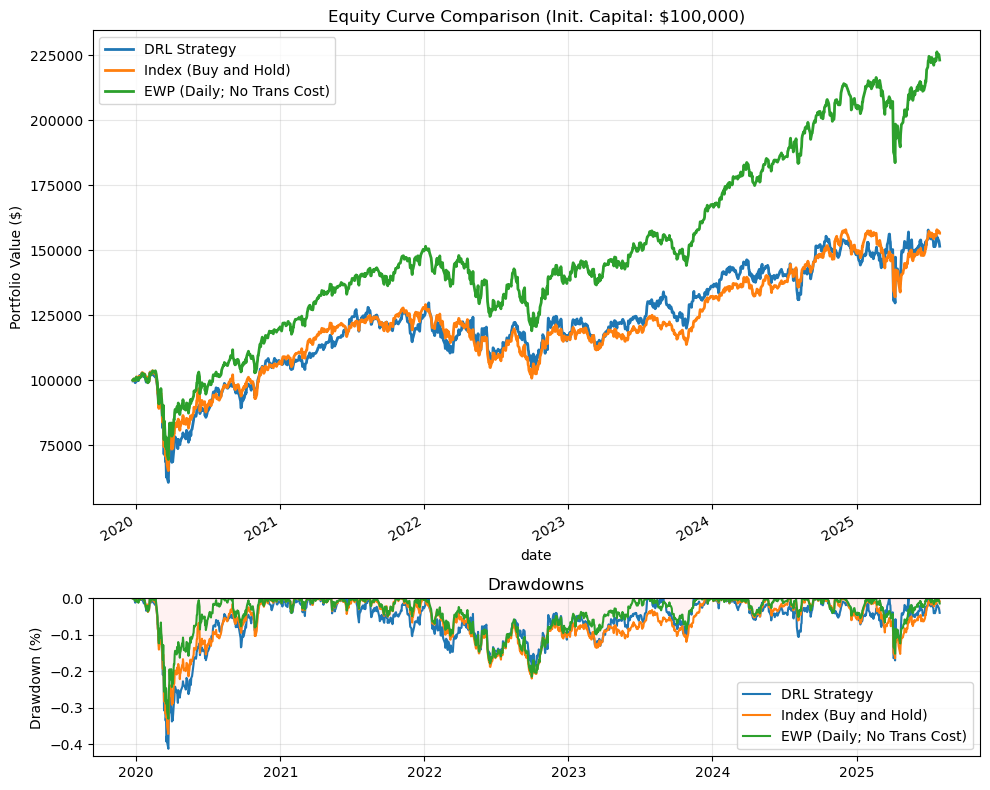

In [8]:
# Plot the equity curves and benchmakrs
backtester.plot_curves()

## Agent Behavior Analysis

In [9]:
# Inspect the trade logs to identify a ticker and long position entry date
display_df(trade_logs)

,date,ticker,action,price,shares,cash_flow,net_profit
0,2019-12-24,NVDA,BUY,5.938970,3359.0,-19998.871424,NaN
1,2019-12-24,TRV,BUY,119.571457,166.0,-19898.484002,NaN
2,2019-12-24,MCD,BUY,171.178787,116.0,-19906.381167,NaN
3,2019-12-24,IBM,BUY,99.688805,200.0,-19987.605328,NaN
4,2019-12-24,PG,BUY,107.831902,185.0,-19998.774041,NaN
5,2019-12-26,NVDA,SELL,5.953158,3359.0,19946.667346,-52.204078
6,2019-12-27,NVDA,BUY,5.895416,3378.0,-19964.501301,NaN
7,2020-01-09,PG,SELL,106.652130,185.0,19681.317463,-317.456578
8,2020-01-10,CVX,BUY,89.099541,222.0,-19829.548283,NaN
9,2020-01-15,MCD,SELL,182.580841,116.0,21126.429120,1220.047952


In [10]:
# Let us pick MCD stock for analysis
SCENARIO_TICKER = 'MCD'
MCD_trade_logs = trade_logs[trade_logs['ticker'] == 'MCD']

# Inspect MCD buy/sell behaviour
display_df(MCD_trade_logs)

,date,ticker,action,price,shares,cash_flow,net_profit
2,2019-12-24,MCD,BUY,171.178787,116.0,-19906.381167,NaN
9,2020-01-15,MCD,SELL,182.580841,116.0,21126.429120,1220.047952
74,2020-06-25,MCD,BUY,161.134369,106.0,-17122.943711,NaN
81,2020-07-21,MCD,SELL,170.145035,106.0,17990.285254,867.341543
117,2020-11-12,MCD,BUY,188.956924,110.0,-20837.224842,NaN
135,2021-02-09,MCD,SELL,192.676056,110.0,21141.380235,304.155392
202,2021-10-14,MCD,BUY,221.928070,107.0,-23805.669256,NaN
204,2021-11-01,MCD,SELL,227.400253,107.0,24270.997535,465.328279
238,2022-03-08,MCD,BUY,204.432755,107.0,-21928.990495,NaN
245,2022-04-06,MCD,SELL,230.740448,107.0,24627.504866,2698.514371


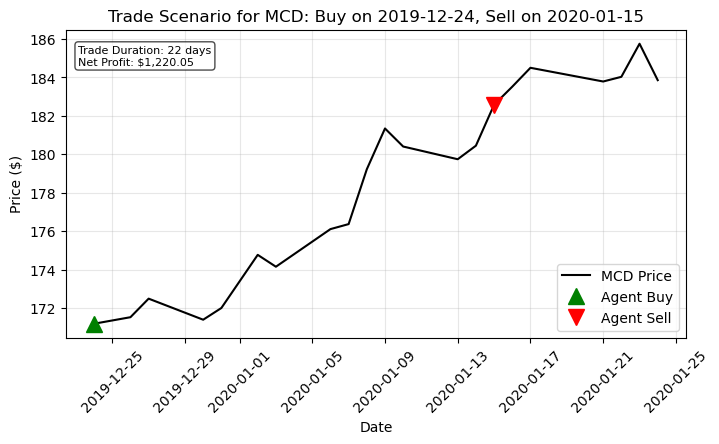

In [11]:
# Set buy/sell date for agent behaviour simulation
BUY_DATE = pd.to_datetime('2019-12-24')
SELL_DATE = pd.to_datetime('2020-01-15')

# Run the trade scenario and visualize
buy_state, buy_rc, sell_state, sell_rc = backtester.get_trade_scenario(BUY_DATE, SCENARIO_TICKER)

# Store the state representations locally for explanability tasks
def save_state_pickle(state_obj: pd.DataFrame | dict[str, float], date: pd.Timestamp, ticker, fname: str) -> None:
    rel_path = lambda fname : f'../data/test/states/{ticker}_{date.strftime("%Y_%m_%d")}_{fname}.pkl'
    with open(rel_path(fname), 'wb') as handle:
        pickle.dump(state_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

save_state_pickle(buy_state, BUY_DATE, SCENARIO_TICKER, 'buy_state')
save_state_pickle(sell_state, SELL_DATE, SCENARIO_TICKER, 'sell_state')
save_state_pickle(buy_rc, BUY_DATE, SCENARIO_TICKER, 'buy_rc')
save_state_pickle(sell_rc, SELL_DATE, SCENARIO_TICKER, 'sell_rc')